In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-02-06 14:07:31.031817: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
images.ndim, labels.ndim

(3, 3)

In [7]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [8]:
p = np.random.permutation(len(images))

In [9]:
images = images[p]
labels = labels[p]

In [10]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [11]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [12]:
images.shape

(503, 512, 512, 1)

In [13]:
labels.shape

(503, 512, 512, 1)

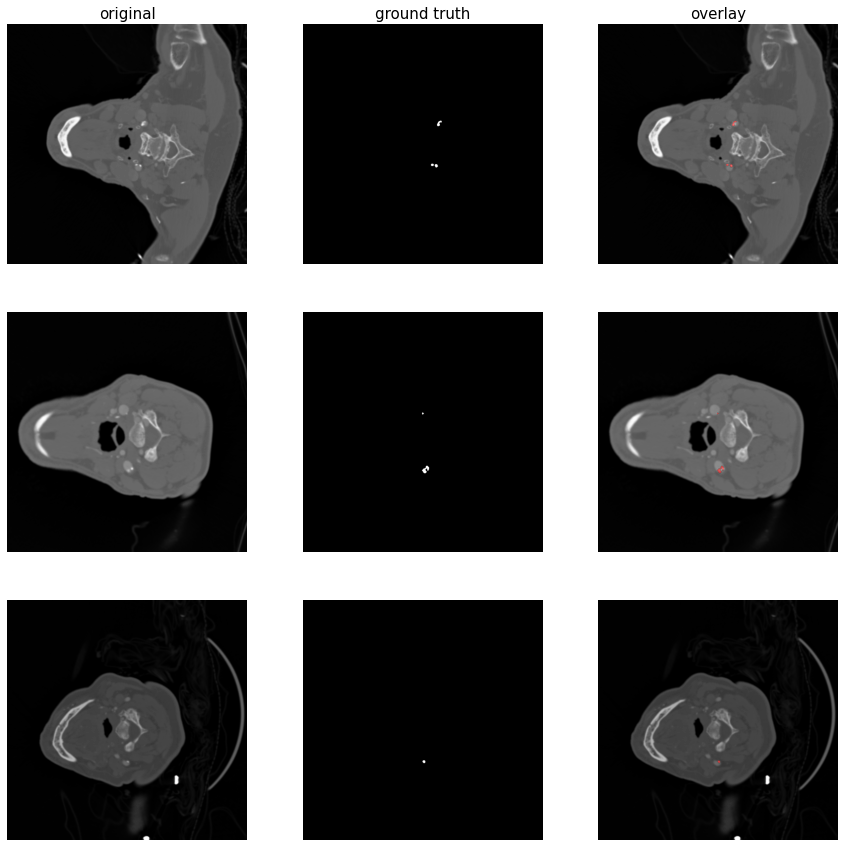

In [14]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [16]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-06 14:07:55.177839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-06 14:07:55.226323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 14:07:55.226357: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 14:07:55.226392: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 14:07:55.226409: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 14:07:55.248161: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-02-06 14:07:55.283427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 14:07:55.286159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-06 14:07:55.291550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-06 14:07:55.292520: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-06 14:07:56.421826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [17]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [18]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=150,
                    validation_data=(X_val, y_val))

2023-02-06 14:08:14.651647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 14:08:14.673167: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/150


2023-02-06 14:08:39.488426: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-06 14:08:41.391437: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-06 14:08:41.391785: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-06 14:08:41.571551: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-06 14:08:41.848114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-06 14:08:43.126573: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-06 14:08:43.126598: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-06 14:08:43.12766

26/26 [==============================] - 52s 897ms/step - loss: 0.0571 - iou: 0.0013 - iou_thresholded: 0.0018 - val_loss: 0.0045 - val_iou: 0.0014 - val_iou_thresholded: 0.0018
Epoch 2/150
26/26 [==============================] - 18s 710ms/step - loss: 0.0036 - iou: 0.0012 - iou_thresholded: 0.0021 - val_loss: 0.0034 - val_iou: 0.0013 - val_iou_thresholded: 0.0018
Epoch 3/150
26/26 [==============================] - 18s 702ms/step - loss: 0.0035 - iou: 0.0015 - iou_thresholded: 0.0014 - val_loss: 0.0023 - val_iou: 0.0019 - val_iou_thresholded: 0.0018
Epoch 4/150
26/26 [==============================] - 18s 704ms/step - loss: 0.0031 - iou: 0.0034 - iou_thresholded: 0.0088 - val_loss: 0.0069 - val_iou: 0.0011 - val_iou_thresholded: 0.0018
Epoch 5/150
26/26 [==============================] - 18s 694ms/step - loss: 0.0044 - iou: 0.0010 - iou_thresholded: 0.0013 - val_loss: 0.0135 - val_iou: 7.6205e-04 - val_iou_thresholded: 0.0011
Epoch 6/150
26/26 [==============================] - 18s 7

26/26 [==============================] - 18s 697ms/step - loss: 2.7376e-04 - iou: 0.4444 - iou_thresholded: 0.5582 - val_loss: 4.7744e-04 - val_iou: 0.3725 - val_iou_thresholded: 0.4641
Epoch 44/150
26/26 [==============================] - 18s 696ms/step - loss: 2.6595e-04 - iou: 0.4680 - iou_thresholded: 0.5816 - val_loss: 4.7102e-04 - val_iou: 0.3861 - val_iou_thresholded: 0.4821
Epoch 45/150
26/26 [==============================] - 18s 700ms/step - loss: 2.5515e-04 - iou: 0.4768 - iou_thresholded: 0.5908 - val_loss: 4.8931e-04 - val_iou: 0.3846 - val_iou_thresholded: 0.4524
Epoch 46/150
26/26 [==============================] - 18s 696ms/step - loss: 2.3541e-04 - iou: 0.5059 - iou_thresholded: 0.6315 - val_loss: 4.8008e-04 - val_iou: 0.3898 - val_iou_thresholded: 0.4613
Epoch 47/150
26/26 [==============================] - 18s 707ms/step - loss: 2.2946e-04 - iou: 0.5071 - iou_thresholded: 0.6321 - val_loss: 4.5085e-04 - val_iou: 0.4082 - val_iou_thresholded: 0.4967
Epoch 48/150
26/26

26/26 [==============================] - 18s 701ms/step - loss: 7.1877e-05 - iou: 0.7995 - iou_thresholded: 0.8946 - val_loss: 5.7638e-04 - val_iou: 0.5094 - val_iou_thresholded: 0.5413
Epoch 85/150
26/26 [==============================] - 18s 697ms/step - loss: 7.6951e-05 - iou: 0.7951 - iou_thresholded: 0.8848 - val_loss: 5.9312e-04 - val_iou: 0.5065 - val_iou_thresholded: 0.5348
Epoch 86/150
26/26 [==============================] - 18s 708ms/step - loss: 7.3659e-05 - iou: 0.7923 - iou_thresholded: 0.8798 - val_loss: 5.7181e-04 - val_iou: 0.5184 - val_iou_thresholded: 0.5493
Epoch 87/150
26/26 [==============================] - 18s 698ms/step - loss: 7.3083e-05 - iou: 0.8030 - iou_thresholded: 0.8897 - val_loss: 6.2325e-04 - val_iou: 0.5026 - val_iou_thresholded: 0.5265
Epoch 88/150
26/26 [==============================] - 18s 704ms/step - loss: 6.9523e-05 - iou: 0.8029 - iou_thresholded: 0.8941 - val_loss: 5.9492e-04 - val_iou: 0.5088 - val_iou_thresholded: 0.5401
Epoch 89/150
26/26

26/26 [==============================] - 18s 701ms/step - loss: 2.7328e-05 - iou: 0.9168 - iou_thresholded: 0.9697 - val_loss: 7.8175e-04 - val_iou: 0.5265 - val_iou_thresholded: 0.5380
Epoch 126/150
26/26 [==============================] - 18s 710ms/step - loss: 2.8043e-05 - iou: 0.9116 - iou_thresholded: 0.9638 - val_loss: 7.8286e-04 - val_iou: 0.5313 - val_iou_thresholded: 0.5444
Epoch 127/150
26/26 [==============================] - 18s 705ms/step - loss: 3.7114e-05 - iou: 0.8983 - iou_thresholded: 0.9492 - val_loss: 8.2231e-04 - val_iou: 0.5173 - val_iou_thresholded: 0.5308
Epoch 128/150
26/26 [==============================] - 18s 702ms/step - loss: 4.6908e-05 - iou: 0.8729 - iou_thresholded: 0.9236 - val_loss: 9.1073e-04 - val_iou: 0.4889 - val_iou_thresholded: 0.4955
Epoch 129/150
26/26 [==============================] - 18s 695ms/step - loss: 1.1523e-04 - iou: 0.7984 - iou_thresholded: 0.8427 - val_loss: 0.0012 - val_iou: 0.4003 - val_iou_thresholded: 0.4054
Epoch 130/150
26/2

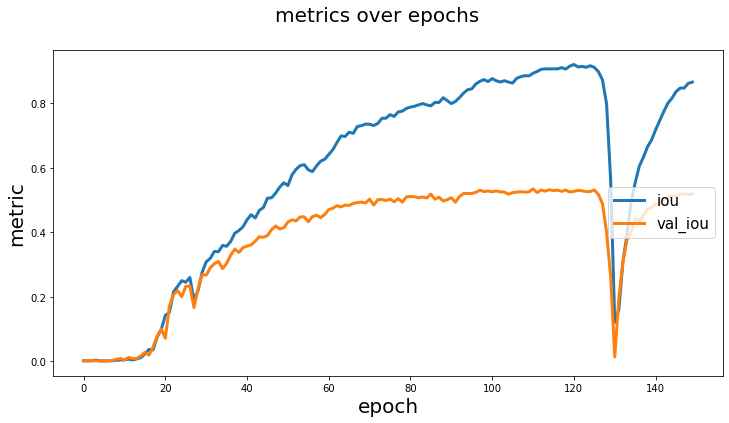

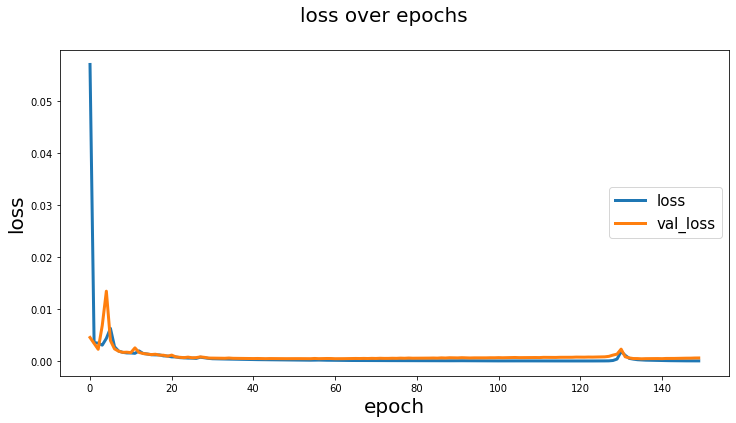

In [21]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [22]:
y_pred = model.predict(X_val)

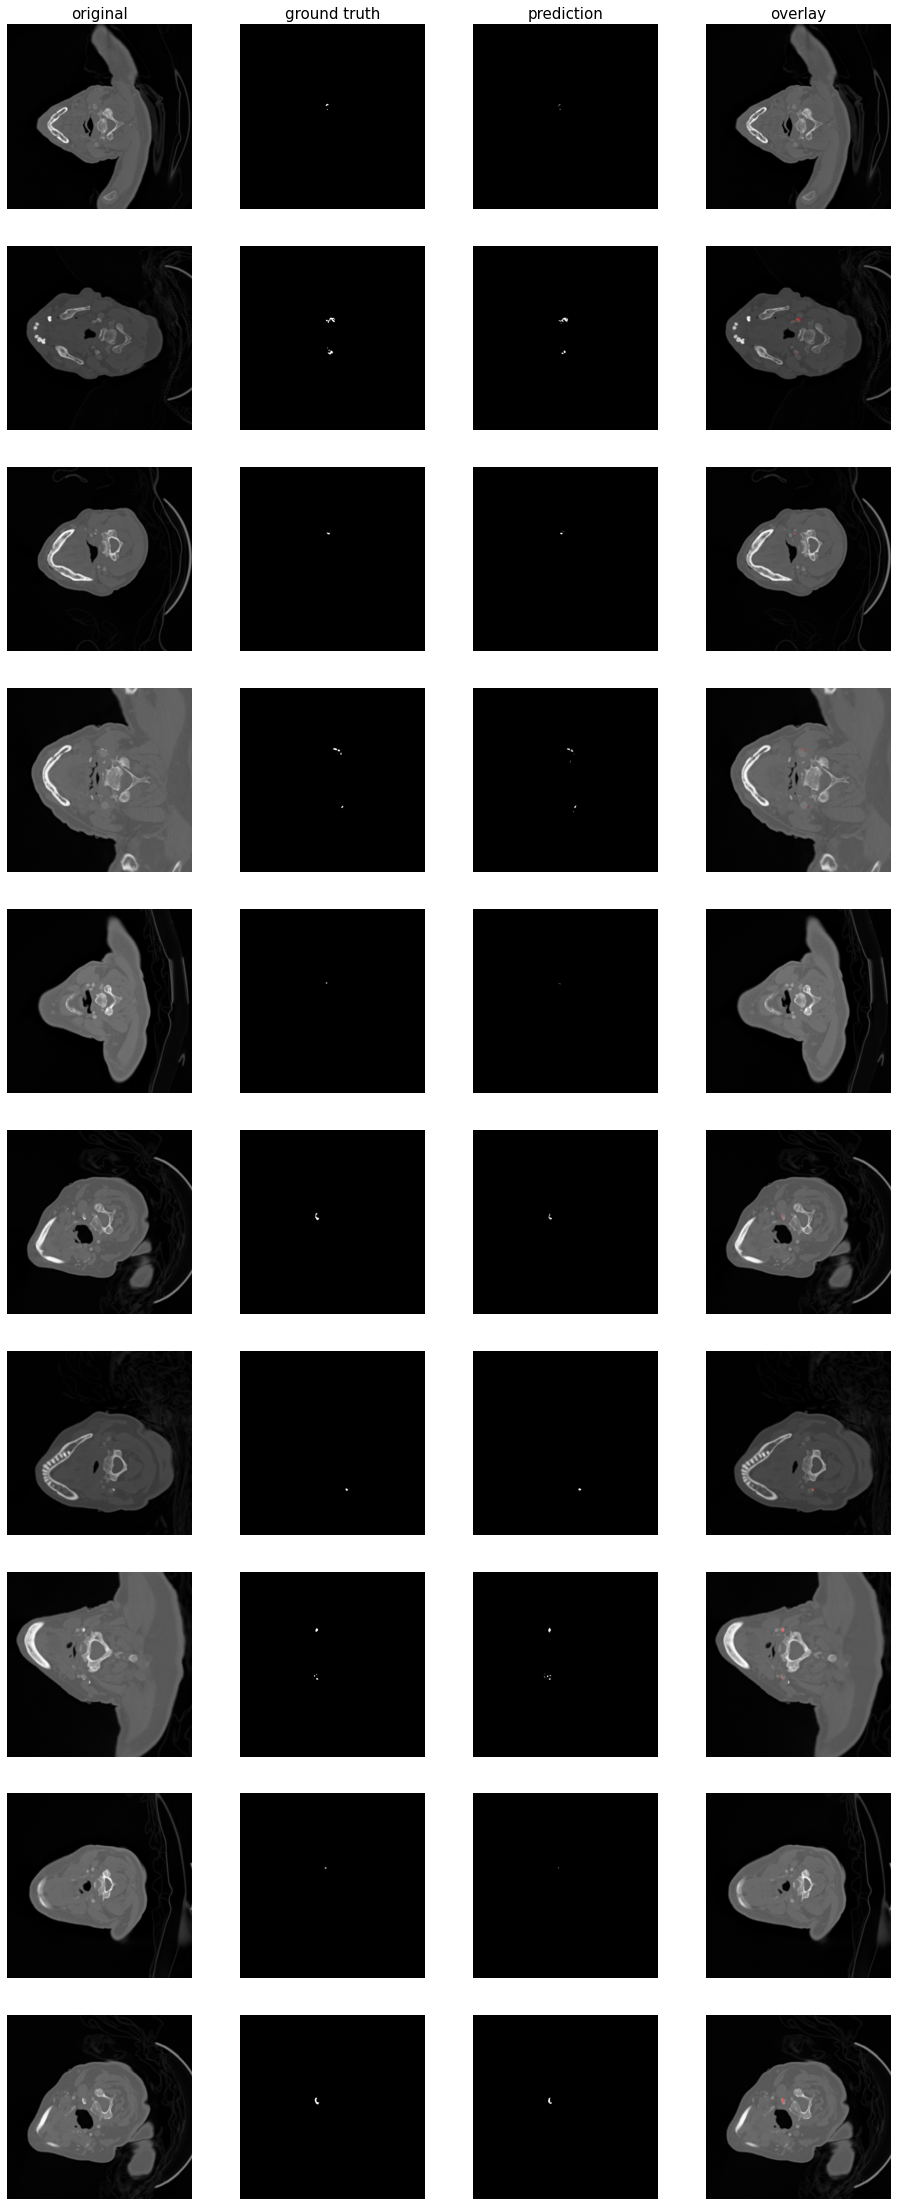

In [24]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [25]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

4/4 [==============================] - 2s 353ms/step - loss: 6.0258e-04 - iou: 0.5220 - iou_thresholded: 0.5471
